# Moneyball ML

Major League Baseball (MLB) has made a shift toward data-driven decision-making in the past 20 years. Initially driven by more traditional statistics that could be compiled by a human scorekeeper, the trend in recent years has been to embrace machine-captured StatCast data to evaluate players. However, many of the statistics cited by baseball enthusiasts and commentators remain those which can be derived from the traditional statistics, and not their richer StatCast counterparts. For example weighted overall batting average aka wOBA, a common metric for hitting performance, is an amalgamation of at-bats, singles, doubles, walks, etc as indicated by the below definition:

wOBA flash 
      Graphic source: FanGraphs, wOBA definition, see https://library.fangraphs.com/offense/woba/

Furthermore, StatCast data is typically used to assess a player's potential, independent or in conjunction with conventional metrics. As extensive information on historical MLB seasons and its players have been compiled, it is possible to analyze StatCast data for its predictive value in the context of other important outcomes such as win rate and run differential. Notably its predictive value here can be compared against the now conventional statistics that rely on the non-Statcast-sourced data. I propose to analyze and model the relationship to predict game outcomes with inputs that are: 
- Strictly sourced from conventional, non-Statcast reporting methods
- Strictly sourced from Statcast
- A combination of A and B above

In so doing, I hope to shed light on the relative value of the newer, more expensive, and often-touted metric source. The data that underpins the proposed analysis is available on the MLB website, a partial list of relevant datasets is provided here: 
- Pitch tempo: https://baseballsavant.mlb.com/leaderboard/pitch-tempo
- Pitch movement: https://baseballsavant.mlb.com/leaderboard/pitch-movement
- Bat tracking : https://baseballsavant.mlb.com/leaderboard/bat-tracking
- Batted ball profile: https://baseballsavant.mlb.com/leaderboard/batted-ball

While the structured nature of these datasets supports classical machine learning (ML) methods, the volume and complexity also provide an interesting testbed for neural-network-based ML algorithms.

In [1]:
from pybaseball import *
cache.enable()

In [ ]:
import re 
import argparse
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import torch.optim as optim
from torch.nn import MSELoss 
from torch.optim import SGD
from skorch import NeuralNetRegressor
from skorch.helper import SkorchDoctor

# Utilities

In [389]:
# Bring in our growing list of utilities and pipeline functions
from data import *
from nn import * 
import mb
import data

# Data

### Catalog

Here are all of the major statistics reported on MLB.com, minus those that blend post-hoc analysis (taints the predictors with run value, wins, etc), composite or less relevant data

- Top Performers : Composite, ignore
- Custom Leaderboards : Composite
- Park Factors : Relevant, but unclear how to incorporate - return to this
- Timer Infractions : Ignore

**Hitting**
- Bat Tracking
- Batted Ball Profile
- Exit Velocity & Barrels
- Expected Statistics
- Home Runs
- Percentile Rankings
- Pitch Arsenal Stats
- Pitch Tempo
- Rolling Windows

**Pitching**
- Active Spin
- Arm Angle
- Bat Tracking
- Exit Velocity & Barrels
- Expected Statistics
- Home Runs
- Percentile Rankings
- Pitch Arsenal Stats - x
- Pitch Arsenals - x
- Pitch Movement
- Pitch Tempo
- Running Game
- Spin Direction - Comparison - x
- Spin Direction - Pitches

**Fielding**
- Arm Strength
- Arm Value
- Catcher Blocking
- Catcher Framing
- Catcher Pop Time
- Catcher Throwing
- Outfield Catch Probability
- Outfield Directional OAA
- Outfielder Jump
- Outs Above Average

**Running**
- Baserunning Run Value
- Basestealing
- Extra Bases Taken
- Sprint Speed

**Positioning**
- Batting Stance
- Batter Positioning
- Fielder - All
- Fielder - Situational
- Pitcher Positioning
- Team Positioning

## Analysis Parameters

In [47]:
year = 2024

## Team Lookup

In [48]:
# No change in teams recently, source from the 2020 data
# Note the trigraph variance between the data sources... fg = FanGraphs, BR = Baseball REfernce, retro = Retrosheet, Lahman = lgID(?) 
teams = team_ids(2020)
teams

,yearID,lgID,teamID,franchID,teamIDfg,teamIDBR,teamIDretro
2875,2020,AL,BAL,BAL,2,BAL,BAL
2876,2020,AL,BOS,BOS,3,BOS,BOS
2877,2020,AL,CHA,CHW,4,CHW,CHA
2878,2020,AL,CLE,CLE,5,CLE,CLE
2879,2020,AL,DET,DET,6,DET,DET
2880,2020,AL,HOU,HOU,21,HOU,HOU
2881,2020,AL,KCA,KCR,7,KCR,KCA
2882,2020,AL,LAA,ANA,1,LAA,ANA
2883,2020,AL,MIN,MIN,8,MIN,MIN
2884,2020,AL,NYA,NYY,9,NYY,NYA


In [49]:
teams.teamID.unique()

array(['BAL', 'BOS', 'CHA', 'CLE', 'DET', 'HOU', 'KCA', 'LAA', 'MIN',
       'NYA', 'OAK', 'SEA', 'TBA', 'TEX', 'TOR', 'ARI', 'ATL', 'CHN',
       'CIN', 'COL', 'LAN', 'MIA', 'MIL', 'NYN', 'PHI', 'PIT', 'SDN',
       'SFN', 'SLN', 'WAS'], dtype=object)

## Player Lookup

In [50]:
register = chadwick_register(save=True)

In [51]:
p = register[register.key_fangraphs == 19470]

In [52]:
if len(p) >= 1: 
    print(p.iloc[0].key_mlbam)

669242


In [53]:
p

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
24,Edman,Tommy,669242,edmat001,edmanto01,19470,2019.0,2025.0


In [54]:
players = register[(register.mlb_played_first <= 2024.0) & (register.mlb_played_last >= 2024.0)]

In [55]:
players.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
21,Miller,Owen,680911,millo002,milleow01,24655,2021.0,2024.0
24,Edman,Tommy,669242,edmat001,edmanto01,19470,2019.0,2025.0
30,Meeker,James,703231,meekj001,meekeja01,-1,2024.0,2024.0
31,Castillo,Diego,660636,castd004,castidi02,19906,2022.0,2024.0
73,Zastryzny,Rob,642239,zastr001,zastrro01,15094,2016.0,2024.0


In [56]:
jwood = players[(players.name_last == 'Wood') & (players.name_first == 'James')]
jwood

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
15788,Wood,James,695578,woodj004,woodja03,-1,2024.0,2025.0


In [57]:
playerid_reverse_lookup([players.iloc[115].key_mlbam])

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,lee,jung hoo,808982,lee-j001,leeju01,33824,2024.0,2025.0


## Spray Chart

In [58]:
batting_df = statcast_batter('2024-01-01', '2024-12-01', 695578)

In [59]:
batting_df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,KC,2024-09-29,79.6,-1.75,5.17,"Wood, James",695578,605400,strikeout,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.81,-1.12,1.12,20.0
1,FF,2024-09-29,93.3,-1.74,5.02,"Wood, James",695578,605400,None,called_strike,...,3,2,6.0,1.0,9.0,NaN,1.54,1.25,-1.25,18.0
2,FF,2024-09-29,92.9,-1.75,5.07,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,1.36,1.10,-1.10,17.5
3,KC,2024-09-29,79.8,-1.82,5.10,"Wood, James",695578,605400,None,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.66,-1.17,1.17,18.5
4,CH,2024-09-29,87.7,-1.75,5.00,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,2.11,1.23,-1.23,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,ST,2024-02-25,86.3,-0.79,5.94,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,2.93,-0.46,0.46,NaN
1573,FF,2024-02-25,93.6,-0.83,6.15,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,1.16,0.39,-0.39,NaN
1574,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,680423,field_out,hit_into_play,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1575,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,685377,home_run,hit_into_play,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
spraychart(data[data['home_team'] == 'WSH'], 'nationals', title='James Wood - April 2024')

TypeError: 'module' object is not subscriptable

## Strike Zone

In [ ]:
players[players.name_last == 'Gore']

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
16740,Gore,MacKenzie,669022,gorem001,gorema01,22201,2022.0,2025.0


In [ ]:
early = statcast_pitcher('2024-04-01', '2024-04-30', 669022)
late = statcast_pitcher('2024-08-01', '2024-08-31', 669022)

Gathering Player Data
Gathering Player Data


In [ ]:
data.pitch_type.unique()

array(['KC', 'FF', 'CH', 'CU', 'SL', 'SI', 'FS', 'FC', 'ST', 'SV', 'CS',
       'KN', nan], dtype=object)

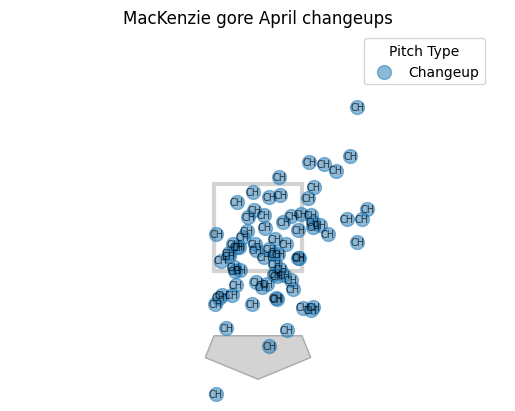

<Axes: title={'center': 'MacKenzie gore April changeups'}>

In [ ]:
plot_strike_zone(early[early.pitch_type == 'CH'], title = "MacKenzie gore April changeups")

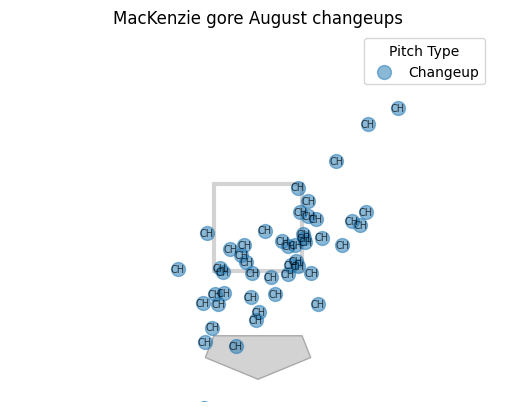

<Axes: title={'center': 'MacKenzie gore August changeups'}>

In [ ]:
plot_strike_zone(late[late.pitch_type == 'CH'], title = "MacKenzie gore August changeups")

## Schedule and Results

In [ ]:
# This is a baseball reference lookup, use the correct trigraph... 
teams.teamIDBR.unique()

array(['BAL', 'BOS', 'CHW', 'CLE', 'DET', 'HOU', 'KCR', 'LAA', 'MIN',
       'NYY', 'OAK', 'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC',
       'CIN', 'COL', 'LAD', 'MIA', 'MIL', 'NYM', 'PHI', 'PIT', 'SDP',
       'SFG', 'STL', 'WSN'], dtype=object)

Interesting to note Washington shows as WSN, WAS and WSH - may need to do some wildcarding depending on the data source

In [ ]:
results = pd.DataFrame()
for team in teams.teamIDBR.unique(): 
    print(f"Retrieving results for {team}...")
    team_results = schedule_and_record(2024, team)
    results = pd.concat([results, team_results])

In [ ]:
results.shape

(4858, 20)

Just 2 games short of the theoretical 162 scheduled games * 30 teams... checks out!

In [ ]:
results.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,"Thursday, Mar 28",BAL,Home,LAA,W,11.0,3.0,9.0,1-0,1.0,Tied,Burnes,Sandoval,None,2:43,D,45029.0,.95,1.0,None
2,"Saturday, Mar 30",BAL,Home,LAA,W,13.0,4.0,9.0,2-0,2.0,0.5,Rodriguez,Canning,None,2:55,D,28420.0,.98,2.0,None
3,"Sunday, Mar 31",BAL,Home,LAA,L,1.0,4.0,9.0,2-1,2.0,1.5,Detmers,Wells,Estévez,2:19,D,20576.0,1.01,-1.0,None
4,"Monday, Apr 1",BAL,Home,KCR,W-wo,6.0,4.0,9.0,3-1,2.0,1.5,Kimbrel,Anderson,None,2:35,N,12666.0,.94,1.0,None
5,"Tuesday, Apr 2",BAL,Home,KCR,L,1.0,4.0,9.0,3-2,3.0,1.5,Marsh,Irvin,Smith,2:17,N,9404.0,1.00,-1.0,None


## Statcast Metrics

See documentation here: https://github.com/jldbc/pybaseball/blob/master/docs/statcast.md

### Pitching

In [53]:
sc_df = statcast("2024-04-01", "2024-04-30")

This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:01<00:00, 26.46it/s]


In [54]:
sc_df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
2825,CH,2024-04-30,81.2,-2.75,5.42,"Crismatt, Nabil",572233,622503,home_run,hit_into_play,...,1,4,2,1,12,1,3.26,0.77,0.77,30.6
2898,CH,2024-04-30,81.4,-2.73,5.47,"Crismatt, Nabil",572233,622503,None,ball,...,1,4,2,1,12,1,2.94,0.43,0.43,30.0
3061,CH,2024-04-30,82.0,-2.63,5.6,"Crismatt, Nabil",572233,622503,None,called_strike,...,1,4,2,1,12,1,3.04,0.68,0.68,34.1
2405,SL,2024-04-30,87.8,-1.57,6.03,"McGough, Scott",606192,543518,field_out,hit_into_play,...,1,4,1,1,3,1,2.62,-0.36,-0.36,46.3
2435,FF,2024-04-30,93.6,-1.49,6.03,"McGough, Scott",606192,543518,None,ball,...,1,4,1,1,3,1,1.0,0.66,0.66,45.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3672,FF,2024-04-01,97.5,1.77,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.95,0.57,-0.57,44.6
3746,FF,2024-04-01,98.6,2.02,5.88,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.91,0.7,-0.7,40.7
3898,FF,2024-04-01,97.7,2.05,5.83,"Gore, MacKenzie",656582,669022,None,foul,...,1,0,<NA>,1,6,3,0.72,0.36,-0.36,40.4
4016,FF,2024-04-01,96.8,2.1,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.91,0.55,-0.55,39.8


In [24]:
sc_pitching = data.load_sc_pitching_base(2024, 'data/')

In [25]:
def unique_vals(df): 
    for c in df.columns: 
        print(c, df[c].unique())

In [ ]:
g = sc_pitching.groupby('pitcher')
g.head()

In [52]:
batting_df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,KC,2024-09-29,79.6,-1.75,5.17,"Wood, James",695578,605400,strikeout,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.81,-1.12,1.12,20.0
1,FF,2024-09-29,93.3,-1.74,5.02,"Wood, James",695578,605400,None,called_strike,...,3,2,6.0,1.0,9.0,NaN,1.54,1.25,-1.25,18.0
2,FF,2024-09-29,92.9,-1.75,5.07,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,1.36,1.10,-1.10,17.5
3,KC,2024-09-29,79.8,-1.82,5.10,"Wood, James",695578,605400,None,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.66,-1.17,1.17,18.5
4,CH,2024-09-29,87.7,-1.75,5.00,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,2.11,1.23,-1.23,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,ST,2024-02-25,86.3,-0.79,5.94,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,2.93,-0.46,0.46,NaN
1573,FF,2024-02-25,93.6,-0.83,6.15,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,1.16,0.39,-0.39,NaN
1574,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,680423,field_out,hit_into_play,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1575,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,685377,home_run,hit_into_play,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df_velo = pybaseball.statcast_pitcher_exitvelo_barrels(2023, minBBE=1)

In [ ]:
df_velo.head()

,"last_name, first_name",player_id,attempts,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,ev50,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa
0,"Mikolas, Miles",571945,674,15.0,38.9,115.5,90.4,80.2,93.7,88.0,479,180,404.0,290,43.0,66,9.8,7.7
1,"Webb, Logan",657277,619,0.6,28.3,114.2,90.7,79.7,95.0,88.8,483,120,403.0,285,46.0,43,6.9,5.1
2,"Corbin, Patrick",571578,605,11.7,37.5,116.3,90.7,80.2,94.2,87.9,444,167,403.0,266,44.0,56,9.3,7.1
3,"Gibson, Kyle",502043,589,8.2,33.3,113.3,89.7,78.4,93.9,86.7,436,151,400.0,262,44.5,45,7.6,5.6
4,"Lyles, Jordan",543475,575,19.8,34.6,115.0,89.0,78.6,92.8,86.1,445,184,402.0,204,35.5,57,9.9,7.6


In [14]:
sc_pitcher_ev = data.load_statcast_pitching_velo(2023, 'data/')

AttributeError: module 'data' has no attribute 'load_statcast_pitching_velo'

In [ ]:
sc_pitcher_expected = statcast_pitcher_expected_stats(year)
sc_pitcher_expected.columns

NameError: name 'year' is not defined

In [ ]:
# Aggregate 
sc_pitch_spin = pd.read_csv("data/active_spin_2024.csv")
sc_pitch_spin

,"last_name, first_name",pitch_hand,active_spin_fourseam,active_spin_sinker,active_spin_cutter,active_spin_changeup,active_spin_splitter,active_spin_curve,active_spin_slider,active_spin_sweeper,active_spin_slurve
0,"Roberts, Ethan",R,NaN,60.2,45.6,NaN,NaN,NaN,NaN,69.5,NaN
1,"Uribe, Abner",R,NaN,69.9,NaN,NaN,NaN,NaN,34.7,NaN,NaN
2,"Ashby, Aaron",L,NaN,83.9,NaN,77.0,NaN,88.1,45.9,NaN,NaN
3,"Bowman, Matt",R,NaN,89.6,60.3,NaN,81.9,NaN,NaN,49.5,NaN
4,"Peguero, Elvis",R,NaN,94.3,NaN,NaN,NaN,NaN,25.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
703,"Cimber, Adam",R,57.3,63.7,NaN,NaN,NaN,NaN,68.2,NaN,NaN
704,"Adams, Austin",R,55.9,54.1,NaN,NaN,NaN,NaN,33.6,NaN,NaN
705,"Cosgrove, Tom",L,55.1,59.1,NaN,NaN,NaN,NaN,NaN,60.6,NaN
706,"Turnbull, Spencer",R,53.3,71.7,NaN,90.0,NaN,87.6,40.9,48.6,NaN


In [ ]:
sc_pitch_spin.index

RangeIndex(start=0, stop=708, step=1)

In [ ]:
# Pitch movement is not a valid symbol in the package despite the docs - pull from baseballsavant.mlb.com manually
sc_pitch_movement = pd.read_csv("data/pitch_movement_2024.csv")
unique_vals(sc_pitch_movement)

year [2024]
last_name, first_name ['Gore, MacKenzie' 'Peralta, Freddy' 'Rodón, Carlos' 'Gausman, Kevin'
 'Greene, Hunter' 'Heaney, Andrew' 'Cease, Dylan' 'Kikuchi, Yusei'
 'Burnes, Corbin' 'Imanaga, Shota' 'Nelson, Ryne' 'Sánchez, Cristopher'
 'Ragans, Cole' 'Cortes, Nestor' 'Gil, Luis' 'Castillo, Luis'
 'Wheeler, Zack' 'Crochet, Garrett' 'Webb, Logan' 'Abbott, Andrew'
 'Bibee, Tanner' 'Singer, Brady' 'Steele, Justin' 'Bassitt, Chris'
 'Valdez, Framber' 'López, Pablo' 'Harrison, Kyle' 'Morton, Charlie'
 'Parker, Mitchell' 'López, Reynaldo' 'Gallen, Zac' 'Pivetta, Nick'
 'Anderson, Tyler' 'Miller, Bryce' 'Irvin, Jake' 'Sale, Chris'
 'Flaherty, Jack' 'Houck, Tanner' 'Suárez, Albert' 'Bello, Brayan'
 'Pepiot, Ryan' 'Canning, Griffin' 'Gomber, Austin' 'Blanco, Ronel'
 'Nola, Aaron' 'Flexen, Chris' 'Corbin, Patrick' 'Estes, Joey' 'Sears, JP'
 'Severino, Luis' 'Ober, Bailey' 'Kirby, George' 'Ryan, Joe'
 'Arrighetti, Spencer' 'Hicks, Jordan' 'Falter, Bailey' 'Brown, Hunter'
 'Spence, Mitch' '

### Batting

In [ ]:
# Batting data!
sc_james_wood = statcast_batter("2024-1-1", "2024-12-31", 695578)

### Fielding 

See docs here: https://github.com/jldbc/pybaseball/blob/master/docs/statcast_fielding.md

In [ ]:
# Aggregate outs above average for the year
sc_fielding_oaa = statcast_outfield_directional_oaa(year, min_opp=1)
sc_fielding_oaa

,"last_name, first_name",player_id,attempts,n_outs_above_average,n_oaa_slice_back_left,n_oaa_slice_back,n_oaa_slice_back_right,n_oaa_slice_back_all,n_oaa_slice_in_left,n_oaa_slice_in,n_oaa_slice_in_right,n_oaa_slice_in_all
0,"Young, Jacob",696285,409,19,1,-2,2,2,5,5,7,18
1,"Varsho, Daulton",662139,348,16,3,4,4,11,2,2,1,5
2,"Siri, Jose",642350,355,16,2,0,2,4,3,4,5,12
3,"Siani, Michael",672279,255,16,3,1,4,8,2,2,5,8
4,"Doyle, Brenton",686668,448,15,3,5,3,11,0,1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
297,"Hernández, Teoscar",606192,337,-9,-2,0,-3,-5,1,-2,-2,-4
298,"Burleson, Alec",676475,147,-9,-3,0,-1,-5,-1,-2,-2,-5
299,"Winker, Jesse",608385,163,-11,-2,-2,-3,-7,-1,-2,-1,-4
300,"García, Adolis",666969,297,-12,-4,-3,-1,-8,-2,1,-2,-3


In [ ]:
# Outfield catch probability is an aggregate statistic, these represent the totality of performance for the individual in the year queried
sc_catch_prob = statcast_outfield_catch_prob(year, min_opp=1)
sc_catch_prob

,"last_name, first_name",player_id,oaa,n_fieldout_5stars,n_opp_5stars,n_5star_percent,n_fieldout_4stars,n_opp_4stars,n_4star_percent,n_fieldout_3stars,n_opp_3stars,n_3star_percent,n_fieldout_2stars,n_opp_2stars,n_2star_percent,n_fieldout_1stars,n_opp_1stars,n_1star_percent
0,"Young, Jacob",696285,19,6,17,35.3,13,18,72.2,15,16,93.8,23,26,88.5,26,26,100.0
1,"Varsho, Daulton",662139,16,3,21,14.3,6,11,54.5,18,22,81.8,22,23,95.7,36,36,100.0
2,"Siri, Jose",642350,16,4,9,44.4,9,16,56.3,22,26,84.6,19,20,95.0,22,24,91.7
3,"Siani, Michael",672279,16,4,16,25.0,5,5,100.0,16,18,88.9,18,18,100.0,22,22,100.0
4,"Doyle, Brenton",686668,15,0,19,0.0,7,14,50.0,24,27,88.9,30,32,93.8,40,40,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,"Hernández, Teoscar",606192,-9,0,24,0.0,1,12,8.3,4,9,44.4,24,29,82.8,28,30,93.3
298,"Burleson, Alec",676475,-9,0,6,0.0,0,7,0.0,0,6,0.0,4,5,80.0,11,13,84.6
299,"Winker, Jesse",608385,-11,0,9,0.0,1,12,8.3,5,9,55.6,6,12,50.0,17,20,85.0
300,"García, Adolis",666969,-12,0,16,0.0,1,10,10.0,5,16,31.3,11,14,78.6,22,25,88.0


In [ ]:
# Catch pop time - throws from release to arrival at targeted base
sc_pop_time = statcast_catcher_poptime(year, min_2b_att=1, min_3b_att=1)
sc_pop_time

,catcher,player_id,team_id,age,maxeff_arm_2b_3b_sba,exchange_2b_3b_sba,pop_2b_sba_count,pop_2b_sba,pop_2b_cs,pop_2b_sb,pop_3b_sba_count,pop_3b_sba,pop_3b_cs,pop_3b_sb
0,"Bailey, Patrick",NaN,137,25,84.6,0.60,58,1.85,1.83,1.86,2,1.40,1.42,1.37
1,"Realmuto, J.T.",NaN,143,33,85.1,0.65,39,1.85,1.85,1.84,4,1.42,1.41,1.45
2,"Lee, Korey",NaN,145,25,88.3,0.64,46,1.85,1.85,1.85,2,1.49,1.56,1.42
3,"Fermin, Freddy",NaN,118,29,84.3,0.64,23,1.88,1.85,1.92,2,1.54,NaN,1.54
4,"Jackson, Alex",NaN,139,28,85.0,0.66,26,1.96,1.86,1.99,2,1.39,NaN,1.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,"Amaya, Miguel",NaN,112,25,80.5,0.70,50,2.04,2.08,2.03,2,1.57,1.64,1.49
69,"Barnes, Austin",NaN,119,34,75.9,0.58,27,2.00,2.09,1.99,2,1.49,1.46,1.52
70,"Del Castillo, Adrian",NaN,109,24,76.9,0.69,13,2.04,2.18,2.02,1,1.60,NaN,1.60
71,"Reetz, Jakson",NaN,137,28,80.3,0.77,3,2.11,NaN,2.11,1,1.53,NaN,1.53


In [ ]:
# Catcher framing
sc_framing = statcast_catcher_framing(year, min_called_p=1)
sc_framing

,last_name,first_name,player_id,year,n_called_pitches,runs_extra_strikes,strike_rate,strike_rate_11,strike_rate_12,strike_rate_13,strike_rate_14,strike_rate_16,strike_rate_17,strike_rate_18,strike_rate_19
0,League Average,None,NaN,2024,144792,0,46.4,18.9,48.1,23.1,58.8,65.7,29.2,49.2,23.4
1,Bailey,Patrick,672275.0,2024,3214,16,52.5,23.3,57.4,28.4,64.6,70.5,29.8,54.8,32.2
2,Raleigh,Cal,663728.0,2024,3404,13,49.1,22.4,55.0,30.0,60.9,68.5,30.0,46.3,28.4
3,Wells,Austin,669224.0,2024,3111,12,48.6,23.0,49.3,23.9,58.1,66.0,31.5,55.1,29.3
4,Kirk,Alejandro,672386.0,2024,2586,10,49.8,21.7,50.7,21.9,67.3,61.2,34.6,56.1,28.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Diaz,Yainer,673237.0,2024,3083,-7,45.2,19.4,54.4,26.6,61.6,62.7,23.0,40.8,22.4
97,Lee,Korey,686676.0,2024,2990,-7,43.0,18.9,45.5,13.7,60.2,60.6,23.2,48.6,19.3
98,Jeffers,Ryan,680777.0,2024,2280,-7,44.6,19.2,50.5,19.2,55.7,59.5,31.0,52.0,15.6
99,Campusano,Luis,669134.0,2024,2130,-8,44.0,17.7,49.7,20.7,46.7,69.1,25.2,48.0,24.4


In [ ]:
# Fielding run value is an aggregate score -- should we employ or does it just pollute the raw predictors? 

### Running

In [ ]:
sc_sprint = statcast_sprint_speed(year, min_opp=1)

In [ ]:
sc_sprint.shape

(606, 10)

In [ ]:
# Aggregate metric, not applicable to any time series
sc_sprint.head()

,"last_name, first_name",player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
0,"Witt Jr., Bobby",677951,118,KC,SS,24,298,156.0,4.10,30.5
1,"Rojas, Johan",679032,143,PHI,CF,23,176,78.0,4.24,30.1
2,"De La Cruz, Elly",682829,113,CIN,SS,22,249,81.0,4.21,30.0
3,"Fitzgerald, Tyler",666149,137,SF,SS,26,99,47.0,4.30,30.0
4,"Clase, Jonatan",682729,141,TOR,LF,22,20,8.0,NaN,30.0


## Conventional Metrics

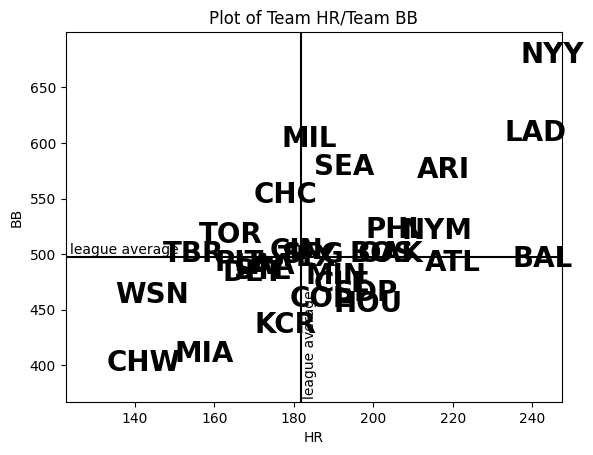

In [ ]:
# https://github.com/jldbc/pybaseball/blob/master/docs/plotting.md
data = team_batting(2024)
plot_teams(data, "HR", "BB")

In [358]:
# API documentation at https://github.com/jldbc/pybaseball/blob/master/docs/batting_stats.md
batting = batting_stats(2023, qual=1)

In [359]:
batting

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
13,18401,2023,Ronald Acuna Jr.,ATL,25,159,643,735,217,137,...,121.2,310,0.552,562,0.137,0.214,0.357,0.660,0.460,8.5
20,5361,2023,Freddie Freeman,LAD,33,161,637,730,211,121,...,110.6,218,0.418,521,0.114,0.208,0.323,0.565,0.408,7.9
17,13611,2023,Mookie Betts,LAD,30,152,584,693,179,99,...,110.1,232,0.481,482,0.205,0.262,0.294,0.563,0.407,8.3
19,14344,2023,Matt Olson,ATL,29,162,608,720,172,88,...,118.6,245,0.551,445,0.130,0.249,0.264,0.558,0.392,6.7
11,19755,2023,Shohei Ohtani,LAA,28,135,497,599,151,73,...,118.6,193,0.533,362,0.125,0.264,0.295,0.638,0.427,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,5933,2023,Jean Segura,MIA,33,85,301,326,66,56,...,114.0,99,0.388,255,0.176,0.268,0.239,0.340,0.281,-1.3
550,20970,2023,Oscar Gonzalez,CLE,25,54,173,180,37,26,...,113.0,52,0.406,128,0.134,0.301,0.237,0.362,0.271,-1.6
494,19901,2023,Gavin Sheets,CHW,27,118,311,344,63,43,...,109.5,81,0.325,249,0.151,0.243,0.210,0.339,0.267,-1.4
501,14691,2023,Harold Castro,COL,29,99,258,270,65,51,...,106.1,56,0.287,195,0.142,0.292,0.242,0.338,0.263,-1.5


In [20]:
data.find_player(name=('Ohtani', 'Shohei'))

np.int64(660271)

In [21]:
batting[batting.IDfg==19755]

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
11,19755,2023,Shohei Ohtani,LAA,28,135,497,599,151,73,...,118.6,193,0.533,362,0.125,0.264,0.295,0.638,0.427,6.6


In [57]:
pitching = pitching_stats(2024, qual=50)

In [58]:
pitching.shape

(351, 393)

In [59]:
len(pitching)

351

In [60]:
pitching.head()

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
25,10603,2024,Chris Sale,ATL,35,18,3,6.4,2.38,29,...,NaN,NaN,NaN,NaN,111,106,112,NaN,NaN,NaN
26,22267,2024,Tarik Skubal,DET,27,18,4,5.9,2.39,31,...,NaN,NaN,NaN,NaN,113,102,115,NaN,NaN,NaN
33,10310,2024,Zack Wheeler,PHI,34,16,7,5.4,2.57,32,...,92.0,95.0,102.0,93.0,109,104,113,NaN,NaN,NaN
77,21846,2024,Cole Ragans,KCR,26,11,9,4.9,3.14,32,...,101.0,NaN,NaN,NaN,112,98,111,NaN,NaN,NaN
117,18525,2024,Dylan Cease,SDP,28,14,11,4.8,3.47,33,...,92.0,NaN,NaN,NaN,110,104,114,NaN,NaN,NaN


In [62]:
pitching[pitching.Team=="LAD"]

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
120,14374,2024,Tyler Glasnow,LAD,30,9,6,3.8,3.49,22,...,NaN,NaN,NaN,NaN,108,101,114,NaN,NaN,NaN
62,33825,2024,Yoshinobu Yamamoto,LAD,25,7,2,2.8,3.00,18,...,108.0,112.0,101.0,109.0,98,106,105,NaN,NaN,NaN
128,27792,2024,Gavin Stone,LAD,25,11,5,2.0,3.53,25,...,95.0,NaN,NaN,NaN,98,102,102,NaN,NaN,NaN
5,25007,2024,Alex Vesia,LAD,28,5,4,1.1,1.76,67,...,NaN,NaN,NaN,NaN,113,99,111,NaN,NaN,NaN
146,17734,2024,Evan Phillips,LAD,29,5,1,0.9,3.62,61,...,101.0,NaN,NaN,NaN,112,104,115,NaN,NaN,NaN
153,27487,2024,Landon Knack,LAD,26,3,5,0.5,3.65,15,...,NaN,NaN,NaN,NaN,94,103,98,NaN,NaN,NaN
311,23221,2024,Michael Grove,LAD,27,4,4,0.4,5.12,39,...,107.0,NaN,NaN,NaN,102,105,109,NaN,NaN,NaN
63,7146,2024,Daniel Hudson,LAD,37,6,2,0.2,3.00,65,...,NaN,NaN,NaN,NaN,104,105,105,NaN,NaN,NaN
320,19374,2024,Walker Buehler,LAD,29,1,6,-0.2,5.38,16,...,115.0,NaN,NaN,NaN,100,96,99,NaN,NaN,NaN
350,27483,2024,Bobby Miller,LAD,25,2,4,-0.9,8.52,13,...,NaN,NaN,NaN,NaN,103,94,100,NaN,NaN,NaN


In [63]:
pitching[pitching.Name=="Shohei Ohtani"]

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO


## Reference Prediction

Naive approach to modeling, merge every feature in and throw an algorithm at it... 

We still need to decide how the data will be composed and made available to the algorithm! Player specific stats are numerous, and create a hierarchical relationship ... perhaps we need to group hitter data and use unsupervised techniques to compress, then do the same for pitchers, runners, fielders ... in this way the predictors are all mashups of those tributary tables. 

- Is there a role for supervised learning in the tributary tables? 

# Modeling

We need to look at: 
- Conventional statistics and how they fare at predicting outcomes
- Statcast statistics and " " " 
- Combined statistics and  " " " 
- Time-series with the subset of statcast metrics that are reported on a temporal basis and the degree to which they can predict wins

In [510]:
import importlib 
from data import *
importlib.reload(data)
importlib.reload(mb) 

<module 'mb' from '/Users/jason/Local/school/520/moneyball-ml/mb.py'>

In [511]:
mb.gpu_survey()

GPU resources not found!


False

In [338]:
X_train, y_train, X_test, y_test = mb.build_train_test_set(standard=True, statcast=True)

In [183]:
X_train.head(10)

,Age_h,G_h,AB,PA,H_h,1B,2B,3B,HR_h,R_h,...,SIERA,RS/9,K-BB%,Pull%_p,Cent%_p,Oppo%_p,Soft%_p,Med%_p,Hard%_p,player_id_p
player_id,,,,,,,,,,,,,,,,,,,,,
408234.0,40.0,98.0,334.0,370.0,86.0,62.0,20.0,0.0,4.0,21.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
444482.0,35.0,133.0,394.0,422.0,102.0,69.0,25.0,1.0,7.0,47.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
425794.0,41.0,23.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.83,4.46,0.029,0.439,0.375,0.186,0.129,0.532,0.339,425794.0
467793.0,37.0,146.0,550.0,619.0,132.0,75.0,33.0,1.0,23.0,78.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
443558.0,42.0,49.0,143.0,152.0,35.0,24.0,5.0,1.0,5.0,9.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
444489.0,36.0,4.0,12.0,12.0,3.0,2.0,0.0,0.0,1.0,1.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
547379.0,34.0,5.0,15.0,17.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
502054.0,35.0,129.0,426.0,481.0,109.0,63.0,27.0,3.0,16.0,55.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
518586.0,34.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


<Axes: ylabel='IDfg'>

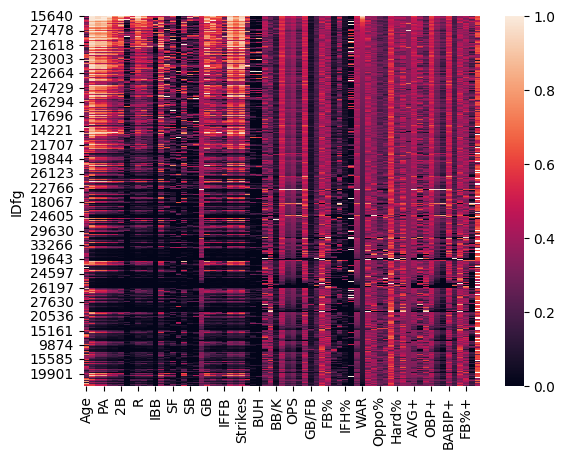

In [381]:
sns.heatmap(mb.scale(std_batting))

<Axes: ylabel='IDfg'>

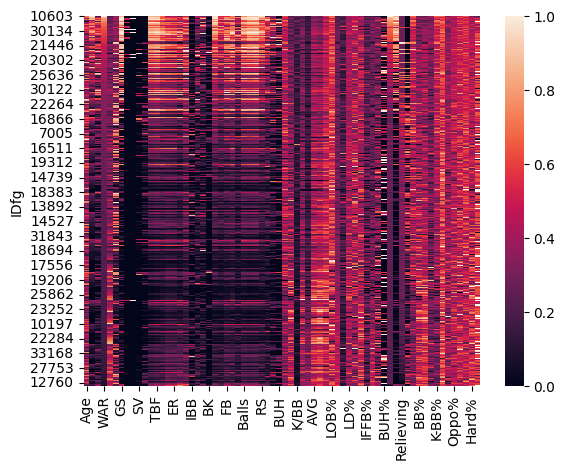

In [382]:
sns.heatmap(mb.scale(std_pitching))

In [512]:
X_train

,Age_h,G_h,AB,PA,H_h,1B,2B,3B,HR_h,R_h,...,position_CF,position_DH,position_LF,position_RF,position_SS,age,competitive_runs,bolts,hp_to_1b,sprint_speed
player_id,,,,,,,,,,,,,,,,,,,,,
408234.0,0.913043,0.602484,0.497758,0.490691,0.396313,0.38750,0.338983,0.000000,0.074074,0.140940,...,0.0,1.0,0.0,0.0,0.0,0.952381,0.380240,0.000000,0.990272,0.757377
444482.0,0.695652,0.819876,0.587444,0.559840,0.470046,0.43125,0.423729,0.090909,0.129630,0.315436,...,0.0,0.0,1.0,0.0,0.0,0.833333,0.583832,0.000000,0.879377,0.885246
425794.0,0.956522,0.136646,0.001495,0.001330,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
467793.0,0.782609,0.900621,0.820628,0.821809,0.608295,0.46875,0.559322,0.090909,0.425926,0.523490,...,0.0,0.0,0.0,0.0,0.0,0.880952,0.658683,0.000000,0.892996,0.849180
443558.0,1.000000,0.298137,0.212257,0.200798,0.161290,0.15000,0.084746,0.090909,0.092593,0.060403,...,0.0,1.0,0.0,0.0,0.0,1.000000,0.116766,0.000000,0.955253,0.809836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677008.0,0.217391,0.074534,0.043348,0.042553,0.032258,0.02500,0.016949,0.000000,0.037037,0.020134,...,0.0,1.0,0.0,0.0,0.0,0.571429,0.014970,0.000000,0.000000,0.914754
687263.0,0.130435,0.515528,0.430493,0.436170,0.299539,0.24375,0.288136,0.000000,0.166667,0.255034,...,0.0,0.0,0.0,0.0,1.0,0.523810,0.326347,0.000000,0.863813,0.908197
685133.0,0.173913,0.118012,0.082212,0.083777,0.059908,0.07500,0.016949,0.000000,0.000000,0.040268,...,1.0,0.0,0.0,0.0,0.0,0.547619,0.071856,0.053691,0.000000,0.963934


In [515]:

X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train)) 

In [516]:
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,329,330,331,332,333,334,335,336,337,338
0,3.244065,0.399098,0.422906,0.402616,0.444276,0.660248,0.661649,-0.647178,-0.518798,-0.451869,...,-0.369274,3.541422,-0.341816,-0.336175,-0.339003,1.865373,0.367007,-0.260464,0.839715,-0.390077
1,1.919541,1.096715,0.735908,0.643861,0.751060,0.870784,1.112269,-0.056355,-0.209234,0.418397,...,-0.369274,-0.282372,2.925547,-0.336175,-0.339003,1.194969,1.225844,-0.260464,0.524917,0.205829
2,3.508970,-1.095795,-1.309038,-1.304660,-1.204687,-1.204494,-1.140832,-0.647178,-0.931551,-1.154777,...,-0.369274,-0.282372,-0.341816,-0.336175,-0.339003,-3.497858,-1.236998,-0.260464,-1.971371,-3.919676
3,2.449351,1.355830,1.549713,1.557810,1.326279,1.051243,1.833262,-0.056355,1.441777,1.456023,...,-0.369274,-0.282372,-0.341816,-0.336175,-0.339003,1.463131,1.541593,-0.260464,0.563577,0.037753
4,3.773875,-0.577566,-0.573484,-0.608759,-0.533597,-0.482658,-0.690211,-0.056355,-0.415610,-0.853530,...,-0.369274,3.541422,-0.341816,-0.336175,-0.339003,2.133534,-0.744429,-0.260464,0.740305,-0.145603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,-0.994412,-1.295114,-1.162971,-1.160840,-1.070469,-1.084188,-1.050708,-0.647178,-0.725175,-1.054361,...,-0.369274,3.541422,-0.341816,-0.336175,-0.339003,-0.279919,-1.173848,-0.260464,-1.971371,0.343345
646,-1.524222,0.120051,0.188154,0.212403,0.041622,-0.031511,0.391277,-0.647178,-0.002858,0.117151,...,-0.369274,-0.282372,-0.341816,-0.336175,2.949829,-0.548081,0.139668,-0.260464,0.480735,0.312786
647,-1.259317,-1.155591,-1.027337,-1.017021,-0.955425,-0.843576,-1.050708,-0.647178,-0.931551,-0.953946,...,2.708013,-0.282372,-0.341816,-0.336175,-0.339003,-0.414000,-0.933879,0.368909,-1.971371,0.572540
648,0.330112,1.236239,1.481896,1.376876,1.767281,1.923461,1.833262,1.125289,0.616271,1.221720,...,-0.369274,-0.282372,2.925547,-0.336175,-0.339003,0.390484,2.299391,-0.260464,0.436553,0.083592


In [518]:
X_train_scaled2 = pd.DataFrame(MinMaxScaler().fit_transform(X_train))

In [519]:
X_train_scaled2

,0,1,2,3,4,5,6,7,8,9,...,329,330,331,332,333,334,335,336,337,338
0,0.913043,0.602484,0.497758,0.490691,0.396313,0.38750,0.338983,0.000000,0.074074,0.140940,...,0.0,1.0,0.0,0.0,0.0,0.952381,0.380240,0.000000,0.990272,0.757377
1,0.695652,0.819876,0.587444,0.559840,0.470046,0.43125,0.423729,0.090909,0.129630,0.315436,...,0.0,0.0,1.0,0.0,0.0,0.833333,0.583832,0.000000,0.879377,0.885246
2,0.956522,0.136646,0.001495,0.001330,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.782609,0.900621,0.820628,0.821809,0.608295,0.46875,0.559322,0.090909,0.425926,0.523490,...,0.0,0.0,0.0,0.0,0.0,0.880952,0.658683,0.000000,0.892996,0.849180
4,1.000000,0.298137,0.212257,0.200798,0.161290,0.15000,0.084746,0.090909,0.092593,0.060403,...,0.0,1.0,0.0,0.0,0.0,1.000000,0.116766,0.000000,0.955253,0.809836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,0.217391,0.074534,0.043348,0.042553,0.032258,0.02500,0.016949,0.000000,0.037037,0.020134,...,0.0,1.0,0.0,0.0,0.0,0.571429,0.014970,0.000000,0.000000,0.914754
646,0.130435,0.515528,0.430493,0.436170,0.299539,0.24375,0.288136,0.000000,0.166667,0.255034,...,0.0,0.0,0.0,0.0,1.0,0.523810,0.326347,0.000000,0.863813,0.908197
647,0.173913,0.118012,0.082212,0.083777,0.059908,0.07500,0.016949,0.000000,0.000000,0.040268,...,1.0,0.0,0.0,0.0,0.0,0.547619,0.071856,0.053691,0.000000,0.963934
648,0.434783,0.863354,0.801196,0.769947,0.714286,0.65000,0.559322,0.272727,0.277778,0.476510,...,0.0,0.0,1.0,0.0,0.0,0.690476,0.838323,0.000000,0.848249,0.859016


In [517]:
mb.scale(X_train)

,Age_h,G_h,AB,PA,H_h,1B,2B,3B,HR_h,R_h,...,position_CF,position_DH,position_LF,position_RF,position_SS,age,competitive_runs,bolts,hp_to_1b,sprint_speed
player_id,,,,,,,,,,,,,,,,,,,,,
408234.0,0.913043,0.602484,0.497758,0.490691,0.396313,0.38750,0.338983,0.000000,0.074074,0.140940,...,0.0,1.0,0.0,0.0,0.0,0.952381,0.380240,0.000000,0.990272,0.757377
444482.0,0.695652,0.819876,0.587444,0.559840,0.470046,0.43125,0.423729,0.090909,0.129630,0.315436,...,0.0,0.0,1.0,0.0,0.0,0.833333,0.583832,0.000000,0.879377,0.885246
425794.0,0.956522,0.136646,0.001495,0.001330,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
467793.0,0.782609,0.900621,0.820628,0.821809,0.608295,0.46875,0.559322,0.090909,0.425926,0.523490,...,0.0,0.0,0.0,0.0,0.0,0.880952,0.658683,0.000000,0.892996,0.849180
443558.0,1.000000,0.298137,0.212257,0.200798,0.161290,0.15000,0.084746,0.090909,0.092593,0.060403,...,0.0,1.0,0.0,0.0,0.0,1.000000,0.116766,0.000000,0.955253,0.809836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677008.0,0.217391,0.074534,0.043348,0.042553,0.032258,0.02500,0.016949,0.000000,0.037037,0.020134,...,0.0,1.0,0.0,0.0,0.0,0.571429,0.014970,0.000000,0.000000,0.914754
687263.0,0.130435,0.515528,0.430493,0.436170,0.299539,0.24375,0.288136,0.000000,0.166667,0.255034,...,0.0,0.0,0.0,0.0,1.0,0.523810,0.326347,0.000000,0.863813,0.908197
685133.0,0.173913,0.118012,0.082212,0.083777,0.059908,0.07500,0.016949,0.000000,0.000000,0.040268,...,1.0,0.0,0.0,0.0,0.0,0.547619,0.071856,0.053691,0.000000,0.963934


In [413]:
import skorch 
import torch 
#Pytorch expects 
# [batch_size, *, in_features]


In [439]:
importlib.reload(nn)

<module 'torch.nn' from '/Users/jason/Local/school/520/moneyball-ml/venv3.12/lib/python3.12/site-packages/torch/nn/__init__.py'>

In [415]:
nn_input_size = len(X_train.columns)

In [486]:
net= skorch.NeuralNetRegressor(
        module=WARNet, 
        criterion=torch.nn.MSELoss, 
        optimizer=torch.optim.SGD, 
        max_epochs=1000, 
        lr=0.0001, 
        module__n_input=nn_input_size, 
        module__n_hidden1=100, 
        batch_size=1, 
        iterator_train__shuffle=True)

In [487]:
dr = skorch.helper.SkorchDoctor(net)

In [488]:
train = MBDataset(mb.scale(X_train), y_train)
test = MBDataset(mb.scale(X_test), y_test)

In [489]:
dr.fit(train)

/Users/jason/Local/school/520/moneyball-ml/venv3.12/lib/python3.12/site-packages/skorch/_doctor.py:154: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  rec_param_update[-1][param_name] = (grad.std() / (eps + tensor.std())).item()


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.0474        2.3544  0.5832
      2        2.2591        1.9631  0.4706
      3        1.9366        1.8303  0.5077
      4        1.7754        1.7557  0.5259
      5        1.6552        1.6719  0.4372
      6        1.5440        1.5824  0.3796
      7        1.4431        1.5088  0.6409
      8        1.3539        1.4588  0.5850
      9        1.2797        1.3793  0.4300
     10        1.2193        1.3496  0.3836
     11        1.1685        1.3013  0.6135
     12        1.1306        1.2839  0.4914
     13        1.0986        1.2684  0.5286
     14        1.0725        1.2654  0.5076
     15        1.0512        1.2415  0.4298
     16        1.0320        1.2272  0.4920
     17        1.0146        1.2062  0.4450
     18        1.0013        1.1919  0.4474
     19        0.9853        1.2253  0.4399
     20        0.9735        1.2066  0.4408
     21        0.9605        1.2

ValueError: x and y must have same first dimension, but have shapes (339,) and (338,)

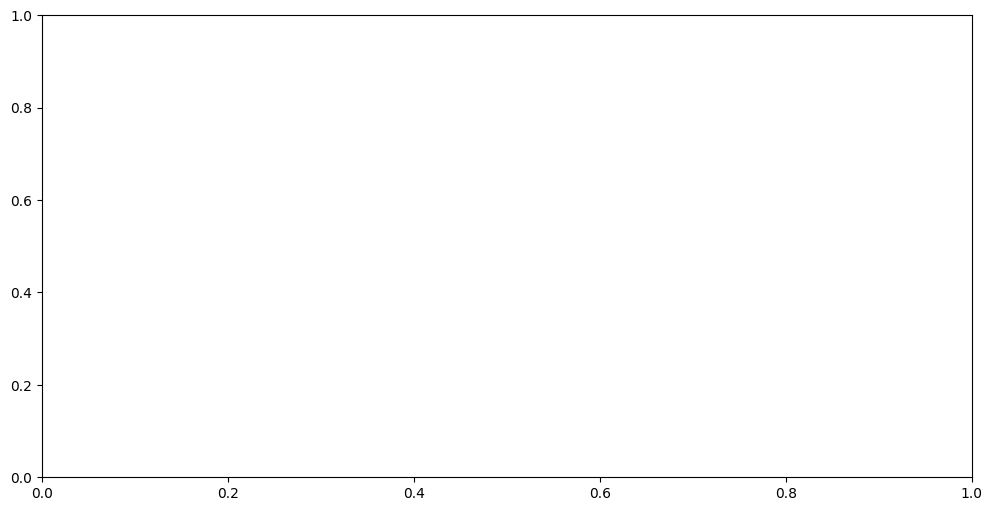

In [507]:
_, ax = plt.subplots(figsize=(12, 6))
dr.plot_loss(ax=ax)
ax.set_ylim([0.5, 0.8]);

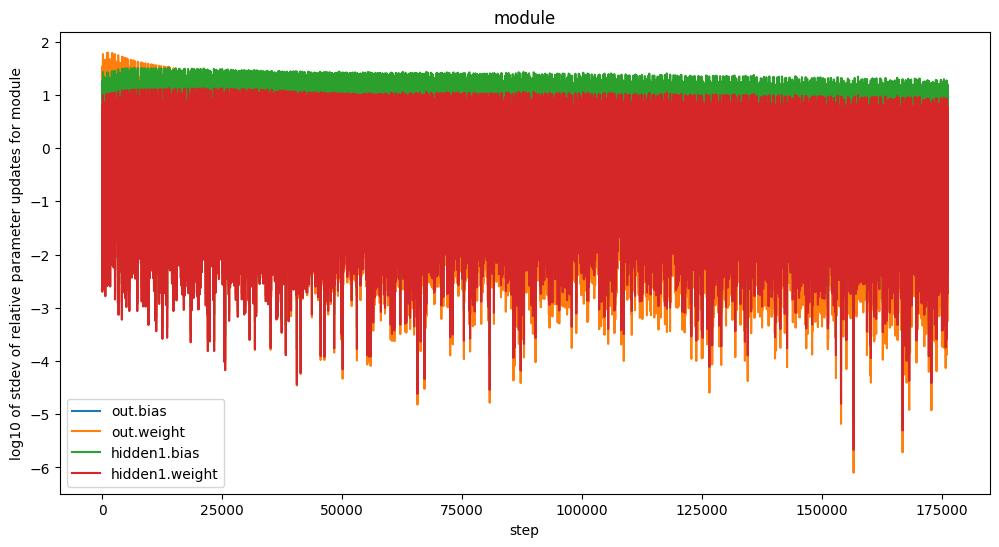

In [491]:
dr.plot_param_updates();

In [ ]:
gpu_survey

In [ ]:
[2, 3] in a 

False

In [504]:
if not a: 
    print('hi')

hi


In [492]:
type(test)

nn.MBDataset

In [498]:
preds = dr.predict(test)

In [499]:
X_test.shape

(559, 339)

In [501]:
import sklearn
sklearn.metrics.mean_squared_error(y_test, preds)

0.46781253814697266